In [96]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import cv2 as cv
from PIL import Image
import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torchsummary import summary
import os 
from torchvision.models import efficientnet_b0, efficientnet_v2_m, EfficientNet_V2_M_Weights
from sklearn.metrics import f1_score

from timm.data.transforms_factory import create_transform


In [2]:
# ! unzip classification/vk-made-sports-image-classification.zip -d classification/dataset

In [119]:
train_df = pd.read_csv('classification/dataset/train.csv')
test_df = pd.read_csv('classification/dataset/test.csv')
encoder = LabelEncoder()
train_df.loc[:, 'label'] = encoder.fit_transform(train_df.loc[:, 'label'])

# присвоим каждому классу свой вес для WeighteRandomSampler, т.к. датасет дисбалансный
class_counts = train_df.label.value_counts()
class_weights = 1/class_counts
sample_weights = [1/class_counts[i] for i in train_df.label.values]
sample_weights[:5]

[0.000779423226812159,
 0.0007704160246533128,
 0.0005022601707684581,
 0.00046511627906976747,
 0.000846740050804403]

In [133]:
# two dataframes for WeighteRandomSampler
from sklearn.model_selection import train_test_split
df_shuffled = train_df.sample(frac=1, random_state=42)
train_dataframe, val_dataframe = train_test_split(df_shuffled, test_size=11000, random_state=42)

# присвоим каждому классу свой вес для WeighteRandomSampler, т.к. датасет дисбалансный
class_counts_train = train_dataframe.label.value_counts()
class_weights_train = 1/class_counts_train
sample_weights_train = [1/class_counts_train[i] for i in train_dataframe.label.values]

class_counts_val = val_dataframe.label.value_counts()
class_weights_val = 1/class_counts_val
sample_weights_val = [1/class_counts_val[i] for i in val_dataframe.label.values]

In [181]:
'4a78b910-ecf1-4532-b0b5-0562621168af.jpeg' in train_dataframe.set_index('image_id').index
# train_dataframe.set_index('image_id')

True

In [191]:
new_folders = False # creation of folders for WeighteRandomSampler
if new_folders:
    import os

    source_folder = 'classification/dataset/train/'
    target_folder1 = 'classification/dataset/train_for_weighted/'
    target_folder2 = 'classification/dataset/val_for_weighted/'

    if not os.path.exists(target_folder1):
        os.makedirs(target_folder1)

    if not os.path.exists(target_folder2):
        os.makedirs(target_folder2)

    for item in os.listdir(source_folder):
        # Construct the source and target file paths
        src_path = os.path.join(source_folder, item)
        target_path = os.path.join(target_folder1 if item in train_dataframe.set_index('image_id').index else target_folder2, item)  # Choose the target folder based on a condition

        # Move the item to the target folder
        os.rename(src_path, target_path)

    _, _, files = next(os.walk('classification/dataset/train_for_weighted/'))
    file_count = len(files)
    print('len of weighted train', file_count)

    _, _, files = next(os.walk('classification/dataset/val_for_weighted/'))
    file_count = len(files)
    print('len of weighted val', file_count)

len of weighted train 34373
len of weighted val 11000


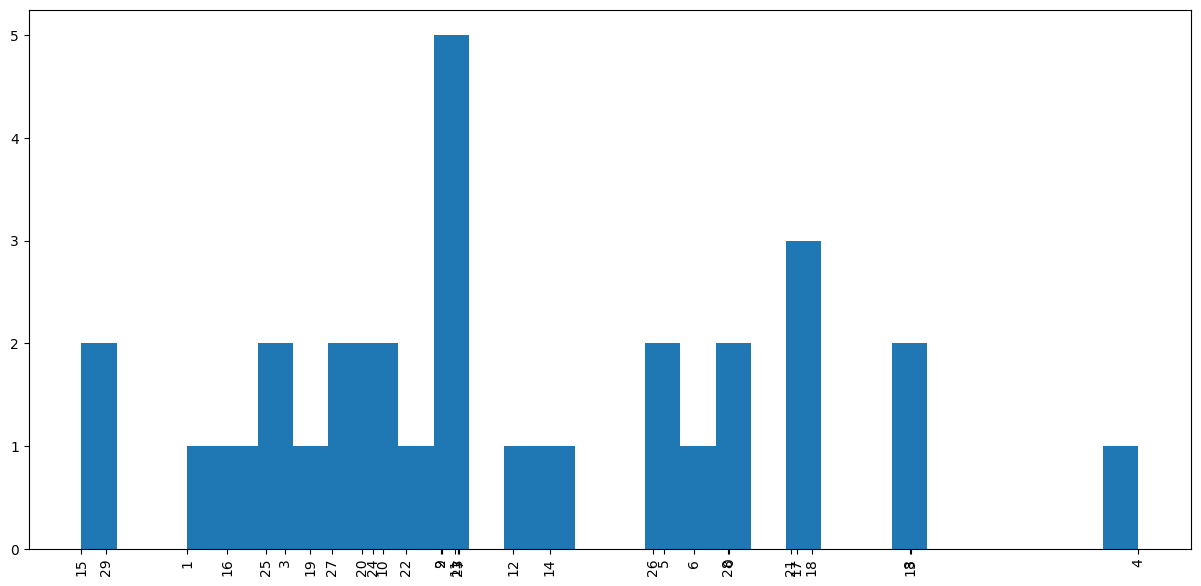

In [5]:
freq = train_df.label.value_counts()
plt.figure(figsize=(15,7))
plt.hist(freq, bins=len(freq))
plt.xticks(freq.values, freq.index, rotation=90)
plt.show()

In [195]:
def load_img(path, prefix):
    img = Image.open(os.path.join(prefix, path))
    img = img.convert('RGB')
    # img = np.array(img)
    return img
    # img = cv.imread(os.path.join(prefix, path))
    # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # return img


class CustomDataset(Dataset):
    def __init__(self, df, prefix, transform = None):
        self.df = df
        self.transform = transform
        self.prefix = prefix
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        image = load_img(self.df.image_id[idx], self.prefix)
        label = self.df.label[idx]

        if self.transform:
            image = self.transform(image)
        # print('image', image.shape)
        # print('label', label)
        return image, torch.tensor(label, dtype=torch.long)
        # return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

transform_img = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((500, 500))
])

In [186]:
def custom_collate_fn(batch):
    av_size1 = 0
    av_size2 = 0
    for item in batch:
        av_size1 += item[0].shape[1]
        av_size2 += item[0].shape[2]
    df = transforms.Resize((av_size1 // len(batch), av_size2 // len(batch)))(batch[0][0])[None,...]
    label = batch[0][1][None,...]
    for i in range(1, len(batch)):
        df = torch.cat([df, transforms.Resize((av_size1 // len(batch), av_size2 // len(batch)))(batch[i][0])[None,...]], dim=0)
        label = torch.cat([label, batch[i][1][None,...]], dim=0)
    if len(batch) == 1:
        df = df[None, ...]
        label = label[None,...]
    return [df, label]

In [187]:
train_path = 'dataset/train.csv'
test_path = 'dataset/test.csv'
dataset = CustomDataset(train_df, 'dataset/train/', transform_img)
dataloader = DataLoader(dataset, batch_size=2, collate_fn=custom_collate_fn)

In [150]:
def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std

In [151]:
# # lets calculate mean and std for the dataaset
# mean, std = batch_mean_and_sd(dataloader)
# print("mean and std: \n", mean, std)

In [231]:
transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((480, 480)),
    transforms.Normalize(mean = [0.4750, 0.4653, 0.4605],
                         std = [0.3051, 0.2943, 0.3057])
])

transform_img_normal1 = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.Normalize(mean = [0.4750, 0.4653, 0.4605],
                         std = [0.3051, 0.2943, 0.3057])
])

transforms_r_and_aug = create_transform(480, 
                 scale=(0.8, 1),
                 is_training=True,
                 auto_augment='rand-m9-n3-mstd0.5',
                 mean=(0.4750, 0.4653, 0.4605),
                 std=(0.3051, 0.2943, 0.3057))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


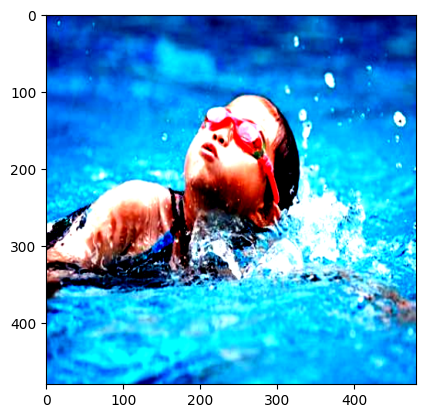

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


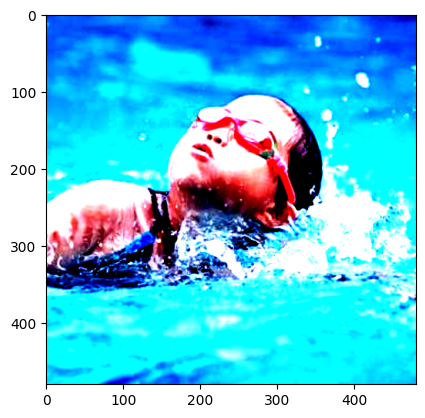

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


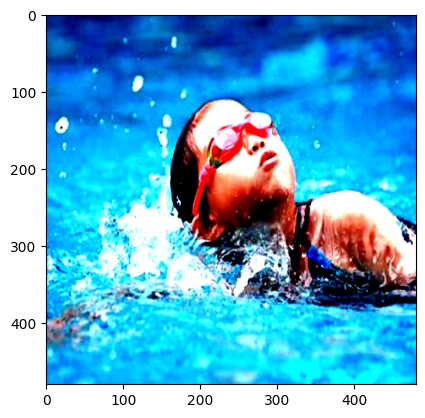

In [153]:
# augmentations from own transformations
img = cv.imread('classification/dataset/train/46514481-2d8b-4d49-8991-012e1bfd34f6.jpeg')
# print(img)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = torch.from_numpy(img.transpose((2, 0, 1)))/255
img1 = transform_img_normal1(img)
plt.imshow(img1.permute(1,2,0))
plt.show()

# augmentations from pytorch model.weights
img = Image.open('classification/dataset/train/46514481-2d8b-4d49-8991-012e1bfd34f6.jpeg')
img = img.convert('RGB')
preprocess = weights.transforms()
img1 = preprocess(img)
plt.imshow(img1.permute(1,2,0))
plt.show()

# augmentations from timm R_and_Augment
img = Image.open('classification/dataset/train/46514481-2d8b-4d49-8991-012e1bfd34f6.jpeg')
img = img.convert('RGB')
# preprocess = weights.transforms()
img1 = transforms_r_and_aug(img)
plt.imshow(img1.permute(1,2,0))
plt.show()

In [154]:
preprocess = weights.transforms()
dataset_train = CustomDataset(train_df, 'classification/dataset/train/', transforms_r_and_aug)

test_len = 11000
train_len = train_df.shape[0]-test_len
train_set, val_set = torch.utils.data.random_split(dataset_train, [train_df.shape[0]-test_len, test_len])
train_loader = DataLoader(train_set, batch_size=32)#, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_set, batch_size=32)#, collate_fn=custom_collate_fn)

dataset_test = CustomDataset(test_path, 'classification/dataset/test/', preprocess)
test_loader = DataLoader(dataset_test, batch_size=32)#, collate_fn=custom_collate_fn)

In [201]:
train_dataframe.reset_index(drop=True)

,image_id,label
0,4a78b910-ecf1-4532-b0b5-0562621168af.jpeg,21
1,2ed3d9bb-491b-449f-b088-7a24c3a401c2.jpeg,16
2,c235a5f6-6a97-444b-bd77-7a37e12eb619.jpeg,7
3,9a6579e2-4748-4f47-952d-f939a482481b.jpeg,16
4,0d485dce-e813-4b91-ab49-418deb651a0d.jpeg,29
...,...,...
34368,47877bb5-e0be-4c58-b4ae-809dc4d4c0e3.jpeg,18
34369,8cac80a4-457a-4a82-bad9-8b0e1a6da121.jpeg,29
34370,77901824-5d56-4f4f-ad84-22e03e7d4e11.jpeg,17
34371,3de7441a-6bf4-4285-8829-761a3ad60fa0.jpeg,8


In [206]:
# lets apply WeightedRandomSampling
from torch.utils.data import WeightedRandomSampler

train_set = CustomDataset(train_dataframe.reset_index(drop=True), 'classification/dataset/train_for_weighted/', transforms_r_and_aug)
val_set = CustomDataset(val_dataframe.reset_index(drop=True), 'classification/dataset/val_for_weighted/', transforms_r_and_aug)

sampler_train = WeightedRandomSampler(weights=sample_weights_train, num_samples=len(train_set), replacement=True)
sampler_val = WeightedRandomSampler(weights=sample_weights_val, num_samples=len(val_set), replacement=True)
train_loader = DataLoader(train_set, sampler=sampler_train, batch_size=32)
val_loader = DataLoader(val_set, sampler=sampler_val, batch_size=32)

In [136]:
train_dataframe.shape#, val_dataframe = train_test_split(df_shuffled, test_size=11000, random_state=42)
# val_dataframe.shape

(34373, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


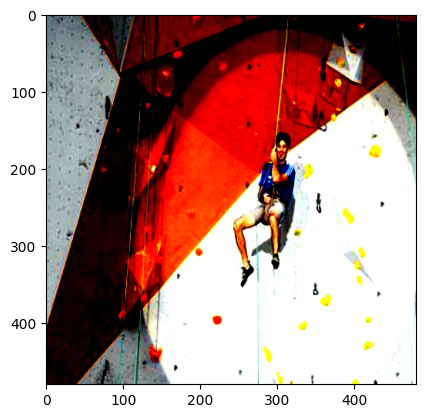

In [207]:
# for im, lab in train_loader:
#   # if i == 2:
#   plt.imshow(im[0].permute(1,2,0))
#   print()
#   # breaik
# print(i)
a = iter(train_loader)
a = a.__next__()[0]
plt.imshow(a[0].permute(1,2,0))

# создание и обучение модели

In [208]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [209]:
from torchmetrics import F1Score

In [210]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_classes = 30

In [211]:
weights = EfficientNet_V2_M_Weights.DEFAULT
model = efficientnet_v2_m(weights=weights)
# model = efficientnet_b0(pretrained=True)
# model = efficientnet_v2_m(pretrained=True)

In [51]:
weights.transforms 
dataset_train = CustomDataset(train_df, 'classification/dataset/train/', weights.transforms)
test_len = 11000
train_len = train_df.shape[0]-test_len
train_set, val_set = torch.utils.data.random_split(dataset_train, [train_df.shape[0]-test_len, test_len])
train_loader = DataLoader(train_set, batch_size=32)#, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_set, batch_size=32)#, collate_fn=custom_collate_fn)

dataset_test = CustomDataset(test_path, 'classification/dataset/test/', transform_img_normal)
test_loader = DataLoader(dataset_test, batch_size=32)#, collate_fn=custom_collate_fn)

a = iter(train_loader)
a = a.__next__()[0]
print(a[0])
plt.imshow(a[0].permute(1,2,0))

TypeError: __init__() takes 1 positional argument but 2 positional arguments (and 3 keyword-only arguments) were given

In [212]:
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(in_features=1280, out_features=n_classes, bias=True)
# finetune_layer = torch.nn.Linear(model.classifier[1].out_features, n_classes)    
model = model.to(device)

In [213]:
import warnings
warnings.filterwarnings("ignore")

In [214]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [28]:
# добавить scheduler

In [ ]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()#label_smoothing=0.05)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

best_metric = -1
best_metric_epoch = 0

early_stopper = EarlyStopper(patience=4)
for epoch in range(30):
    total_correct = 0
    running_loss = 0
    model.train()
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        # with torch.no_grad():
        pred = model(img)
        optimizer.zero_grad()
        # pred = finetune_layer(features)
        # total_correct += (label == torch.argmax(pred, dim=1)).sum().item()
        targets_cpu = label.clone().detach().cpu().numpy()
        preds_cpu = torch.argmax(pred, dim=1).clone().detach().cpu().numpy()
        f1 = F1Score(task="multiclass", average = 'micro', num_classes=n_classes).to(device)
        f1.update(torch.argmax(pred, dim=1), label)
        loss = criterion(pred, label)
        running_loss += loss.item() * img.size(0)
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        optimizer.step()


    final_f1 = f1.compute()
    print(f'Train epoch {epoch}, loss {running_loss / train_len}, f1-score {final_f1}')

    with torch.no_grad():
        model.eval()
        total_loss = 0
        total_correct = 0

        for img, label in val_loader:
            img, label = img.to(device), label.to(device)
            # pred = finetune_layer(model(img))
            pred = model(img)
            loss = criterion(pred, label)
            targets_cpu = label.clone().detach().cpu().numpy()
            preds_cpu = torch.argmax(pred, dim=1).clone().detach().cpu().numpy()
            f1 = F1Score(task="multiclass", average = 'micro', num_classes=n_classes).to(device)
            f1.update(torch.argmax(pred, dim=1), label)
            total_loss += loss.item() * img.size(0)

        final_f1 = f1.compute()
        if final_f1 >= best_metric:
            best_metric = final_f1
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), "best_model_sports.pth")
            print("saved new best metric model")

    # print(f'Val epoch {epoch}, loss {total_loss / test_len}, accuracy {total_correct / test_len}')

    print(f'Val epoch {epoch}, loss {total_loss / test_len}, f1-score {final_f1}, best f1 {best_metric}, best_metric_epoch {best_metric_epoch}')

    scheduler.step(total_loss)

Train epoch 0, loss 0.943893738979478, f1-score 0.6000000238418579
saved new best metric model
Val epoch 0, loss 0.6023954040353948, f1-score 0.7083333134651184, best f1 0.7083333134651184, best_metric_epoch 1
Train epoch 1, loss 0.6338874539587186, f1-score 1.0
saved new best metric model
Val epoch 1, loss 0.5628943198377436, f1-score 0.75, best f1 0.75, best_metric_epoch 2
Train epoch 2, loss 0.5933669820864442, f1-score 1.0
saved new best metric model
Val epoch 2, loss 0.5705094391215931, f1-score 0.75, best f1 0.75, best_metric_epoch 3
Train epoch 3, loss 0.5674040241904627, f1-score 1.0
saved new best metric model
Val epoch 3, loss 0.5215861659049987, f1-score 0.8333333134651184, best f1 0.8333333134651184, best_metric_epoch 4
Train epoch 4, loss 0.5721730968115879, f1-score 1.0
saved new best metric model
Val epoch 4, loss 0.5287914012020285, f1-score 0.9583333134651184, best f1 0.9583333134651184, best_metric_epoch 5
Train epoch 5, loss 0.5540197249164345, f1-score 1.0
Val epoch

## Validation

In [224]:
test_df = pd.read_csv('classification/dataset/test.csv')

In [235]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = efficientnet_b0(pretrained=True)
# model.classifier[1] = nn.Linear(in_features=1280, out_features=30, bias=True)
# model = model.to(device)
# model.load_state_dict(torch.load("best_model_sports.pth"))
weights = EfficientNet_V2_M_Weights.DEFAULT
model = efficientnet_v2_m(weights=weights)

model.classifier[1] = nn.Linear(in_features=1280, out_features=n_classes, bias=True)
model = model.to(device)
model.load_state_dict(torch.load("best_model_sports.pth"))


<All keys matched successfully>

In [236]:
def custom_collate_fn_test(batch):
    av_size1 = 0
    av_size2 = 0
    for item in batch:
        av_size1 += item.shape[1]
        av_size2 += item.shape[2]
    df = transforms.Resize((av_size1 // len(batch), av_size2 // len(batch)))(batch[0])[None,...]
    for i in range(1, len(batch)):
        df = torch.cat([df, transforms.Resize((av_size1 // len(batch), av_size2 // len(batch)))(batch[i])[None,...]], dim=0)
    if len(batch) == 1:
        df = df[None, ...]
    return df

In [237]:
class TestDataset(Dataset):
    def __init__(self, df, prefix, transform = None):
        self.df = df
        self.transform = transform
        self.prefix = prefix
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        image = load_img(self.df.image_id[idx], self.prefix)

        if self.transform:
            image = self.transform(image)
        return torch.tensor(image, dtype=torch.float)

transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((480, 480)),
    transforms.Normalize(mean = [0.4750, 0.4653, 0.4605],
                         std = [0.3051, 0.2943, 0.3057])
])

In [238]:
dataset_test = TestDataset(test_df, 'classification/dataset/test/', transform_img_normal)
test_loader = DataLoader(dataset_test, batch_size=32)#, collate_fn=custom_collate_fn_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


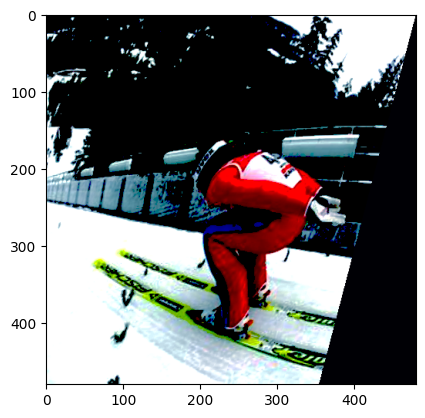

In [239]:
a = iter(test_loader)
a = a.__next__()[0]
plt.imshow(a.permute(1,2,0))

In [240]:
model.eval()
with torch.no_grad():
    df = np.array([])
    for val_data in test_loader:
        val_images = val_data.to(device)
        val_outputs = model(val_images)
        df = np.append(df, val_outputs.argmax(dim=1).detach().cpu().numpy())

In [242]:
result_df = test_df.copy()
result_df = pd.concat([result_df, pd.Series(df, name='label')], axis=1)
result_df['label'] = result_df['label'].astype('int64')
result_df['label'] = encoder.inverse_transform(result_df['label'])
result_df#.to_csv('classification/dataset/result.csv', index=False)

,image_id,label
0,00fd3c23-193c-480a-aef9-bb438d50d79e.jpeg,ski_race
1,ef5473b9-a558-4f38-acd0-be4ecfde5a23.jpeg,basketball
2,ba00f9b4-7cbf-4110-91ea-ed41f5cb4ee4.jpeg,alpinism
3,f1bdf877-4379-4e00-b5b8-1e90bdcbda76.jpeg,tennis
4,4c96ff83-07e3-45a4-934f-a92ebf49b299.jpeg,fencing
...,...,...
19441,01ec2a50-db12-4b98-94da-1dd9372650cf.jpeg,skating
19442,1596a0c0-5772-4309-8781-47e15dcdd5d5.jpeg,boxing
19443,65610b2c-c137-468a-85a6-a3ec2ed9e87f.jpeg,basketball
19444,5630e635-fce1-4a33-8748-b7416d16fffc.jpeg,water_polo


In [243]:
result_df.to_csv('classification/dataset/result.csv', index=False)